# Telecom Churn Prediction - Starter Notebook



The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [4]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [5]:
#Read the train,test,sample,data_dict files

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


# Data Understanding and Preprocessing

1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [6]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [7]:
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

Let's look at each variable's datatype:

In [8]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Let's also summarize the features using the df.describe method:

In [9]:
data.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  67312.000000  ...  69999.000000  69999.000000  17568.000000   
mean     133.894438  ...      0.081444      0.085487      0.916325   
std      311.277193  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.675000  ...      0.000000      0.000000      1.000000   
50%       32.280000  ...      0.000000      0.000000      1.000000   
75%      115.837500  ...      0.000000      0.000000      1.000000   
max     8157.780000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 163 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

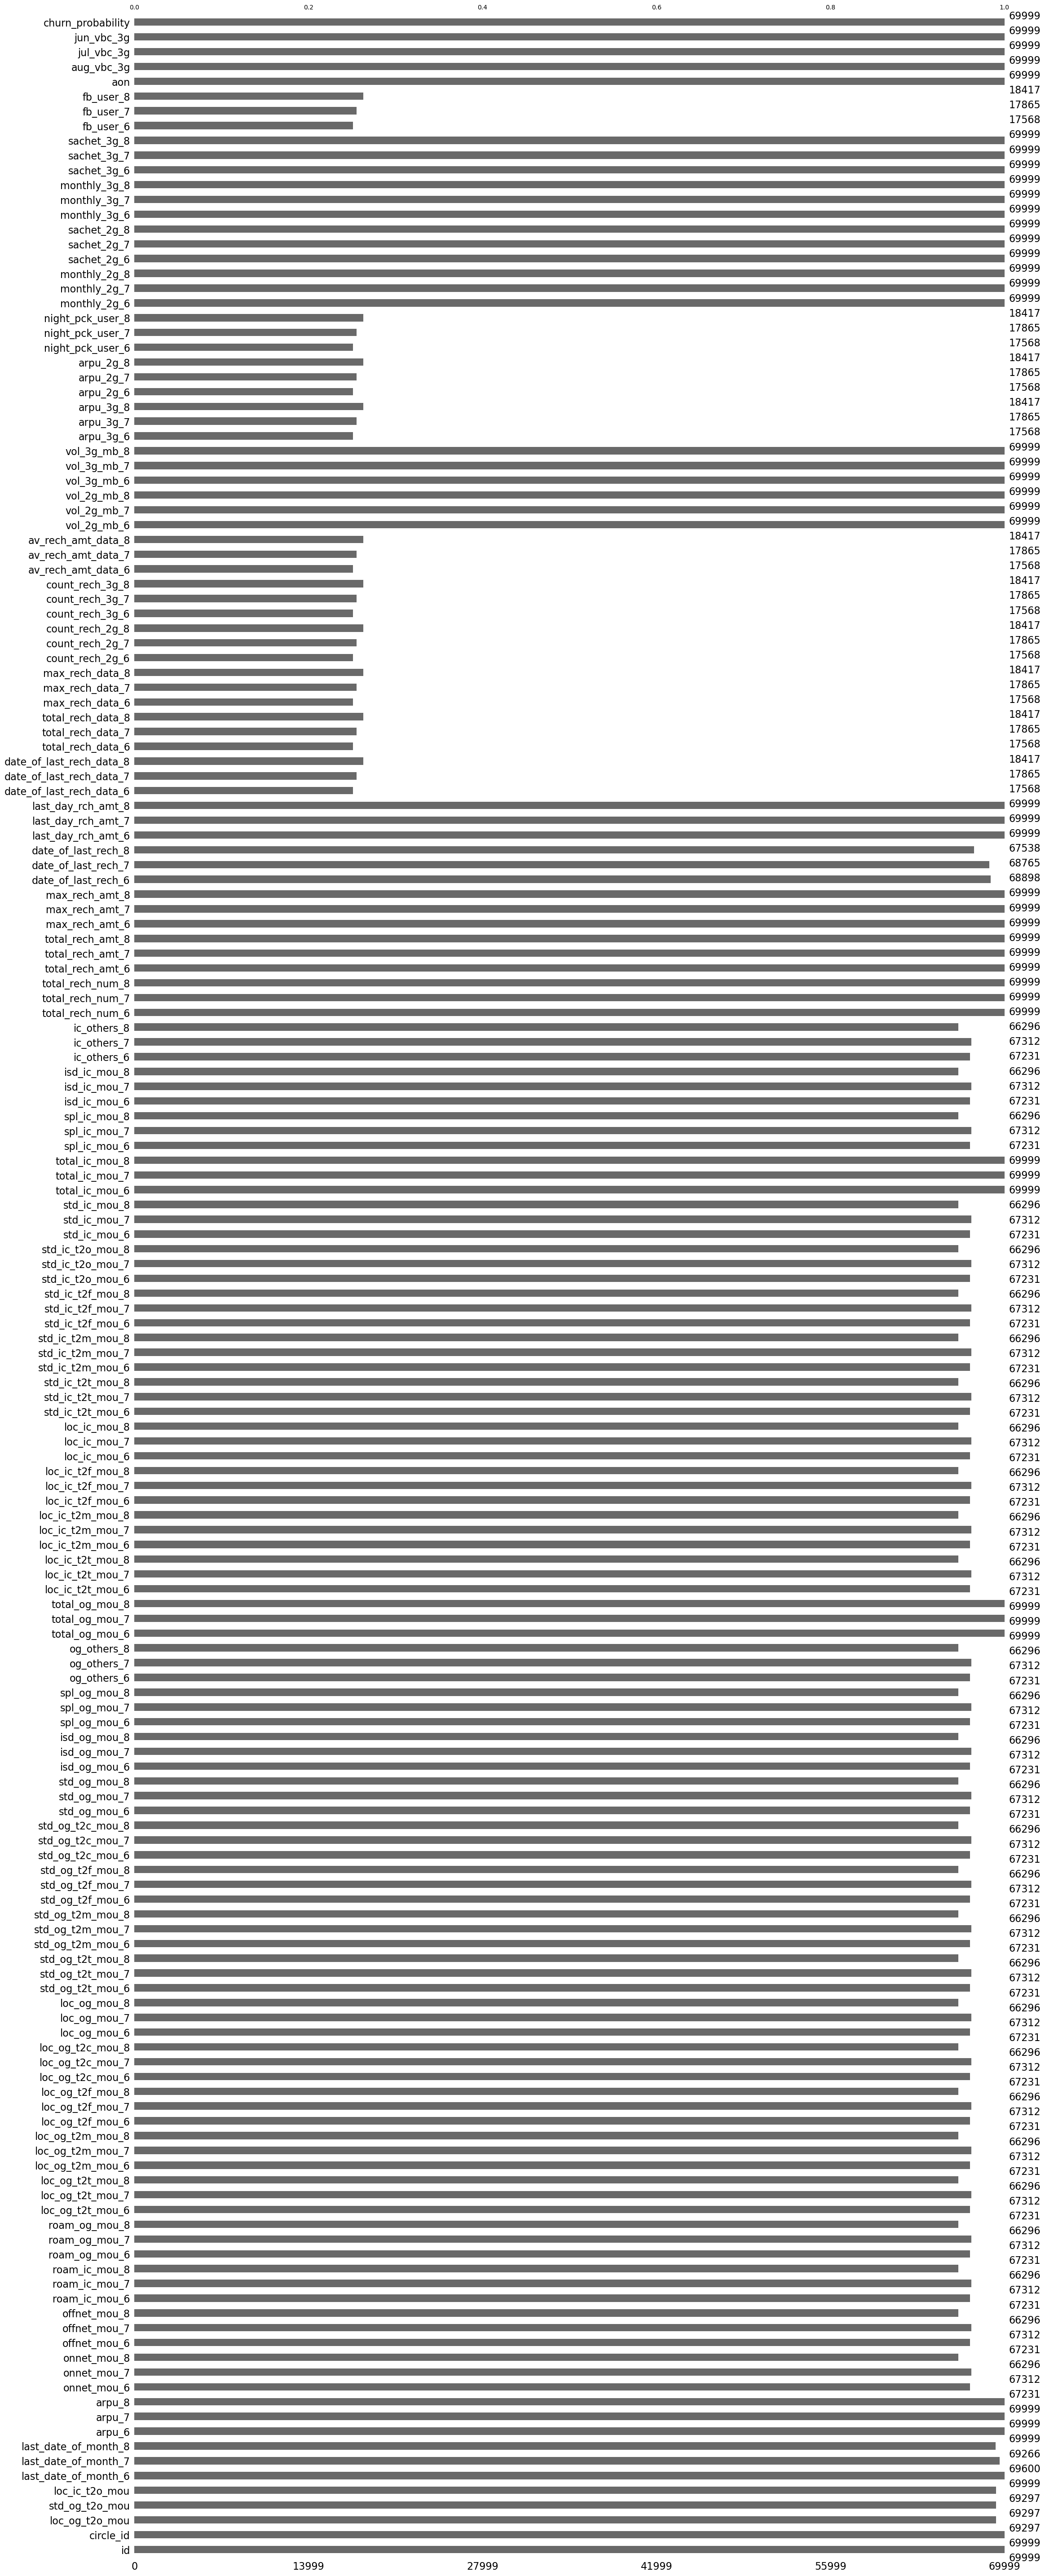

In [10]:
msno.bar(data)

<Axes: >

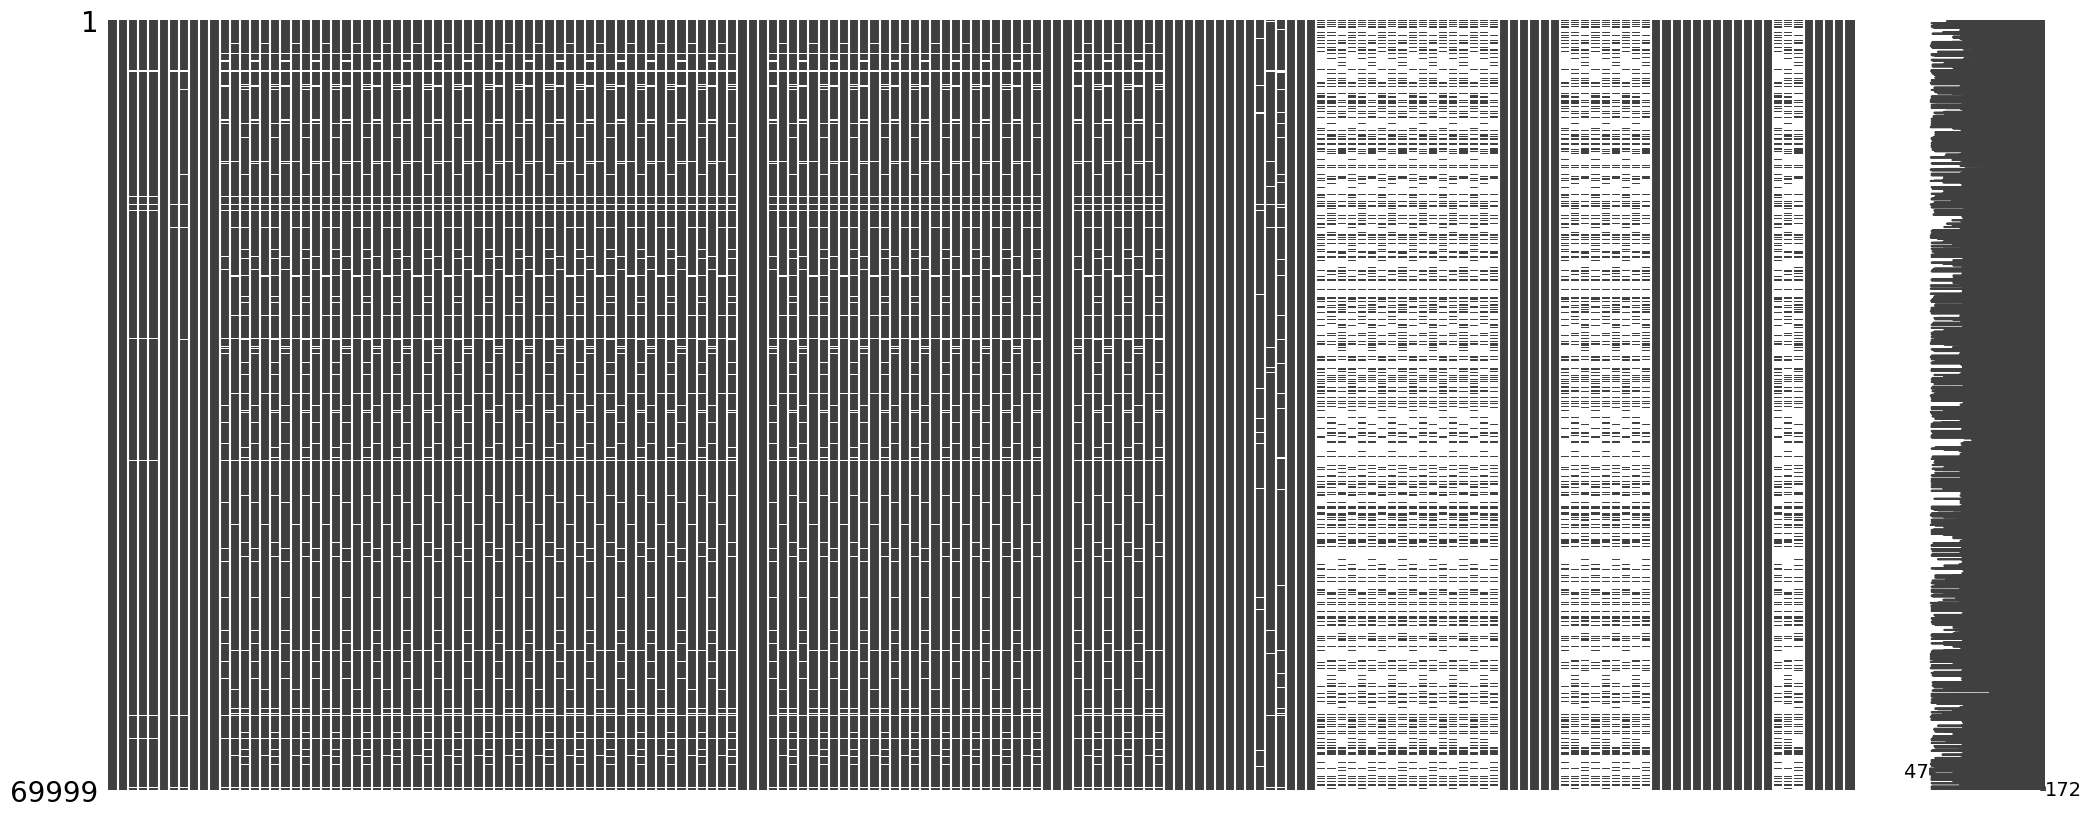

In [11]:
msno.matrix(data)

Lets also calculate the % missing data for each column:

In [12]:
missing_data_percent = 100*data.isnull().sum()/len(data['churn_probability'])
missing_data_percent

id                           0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.002871
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_m

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [13]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=142)

In [14]:
X_train_filtered = data[new_vars]
X_train_filtered.shape

(69999, 142)

# Remove the columns which have single unique values

In [15]:
cols_with_single_value = []
for col in X_train_filtered.columns:
    if X_train_filtered[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [16]:
X_train_filtered=X_train_filtered.drop(columns=cols_with_single_value,axis=1)

In [17]:
X_train_filtered.shape

(69999, 129)

# Check for Null or empty values in columns

In [18]:
X_train_filtered.isnull().sum()

id                        0
arpu_6                    0
arpu_7                    0
arpu_8                    0
onnet_mou_6            2768
onnet_mou_7            2687
onnet_mou_8            3703
offnet_mou_6           2768
offnet_mou_7           2687
offnet_mou_8           3703
roam_ic_mou_6          2768
roam_ic_mou_7          2687
roam_ic_mou_8          3703
roam_og_mou_6          2768
roam_og_mou_7          2687
roam_og_mou_8          3703
loc_og_t2t_mou_6       2768
loc_og_t2t_mou_7       2687
loc_og_t2t_mou_8       3703
loc_og_t2m_mou_6       2768
loc_og_t2m_mou_7       2687
loc_og_t2m_mou_8       3703
loc_og_t2f_mou_6       2768
loc_og_t2f_mou_7       2687
loc_og_t2f_mou_8       3703
loc_og_t2c_mou_6       2768
loc_og_t2c_mou_7       2687
loc_og_t2c_mou_8       3703
loc_og_mou_6           2768
loc_og_mou_7           2687
loc_og_mou_8           3703
std_og_t2t_mou_6       2768
std_og_t2t_mou_7       2687
std_og_t2t_mou_8       3703
std_og_t2m_mou_6       2768
std_og_t2m_mou_7    

Remove Date columns

In [19]:
datecols=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']

In [20]:
X_train_filtered=X_train_filtered.drop(datecols,axis=1)

In [21]:
X_train_filtered.shape

(69999, 126)

Get Columns with missing values 

In [22]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

# Fill Missing Values in both input and unseen data

In [23]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])
unseen[impute_cols]=imp.transform(unseen[impute_cols])
                            

Plot and check for nulll values if any 

<Axes: >

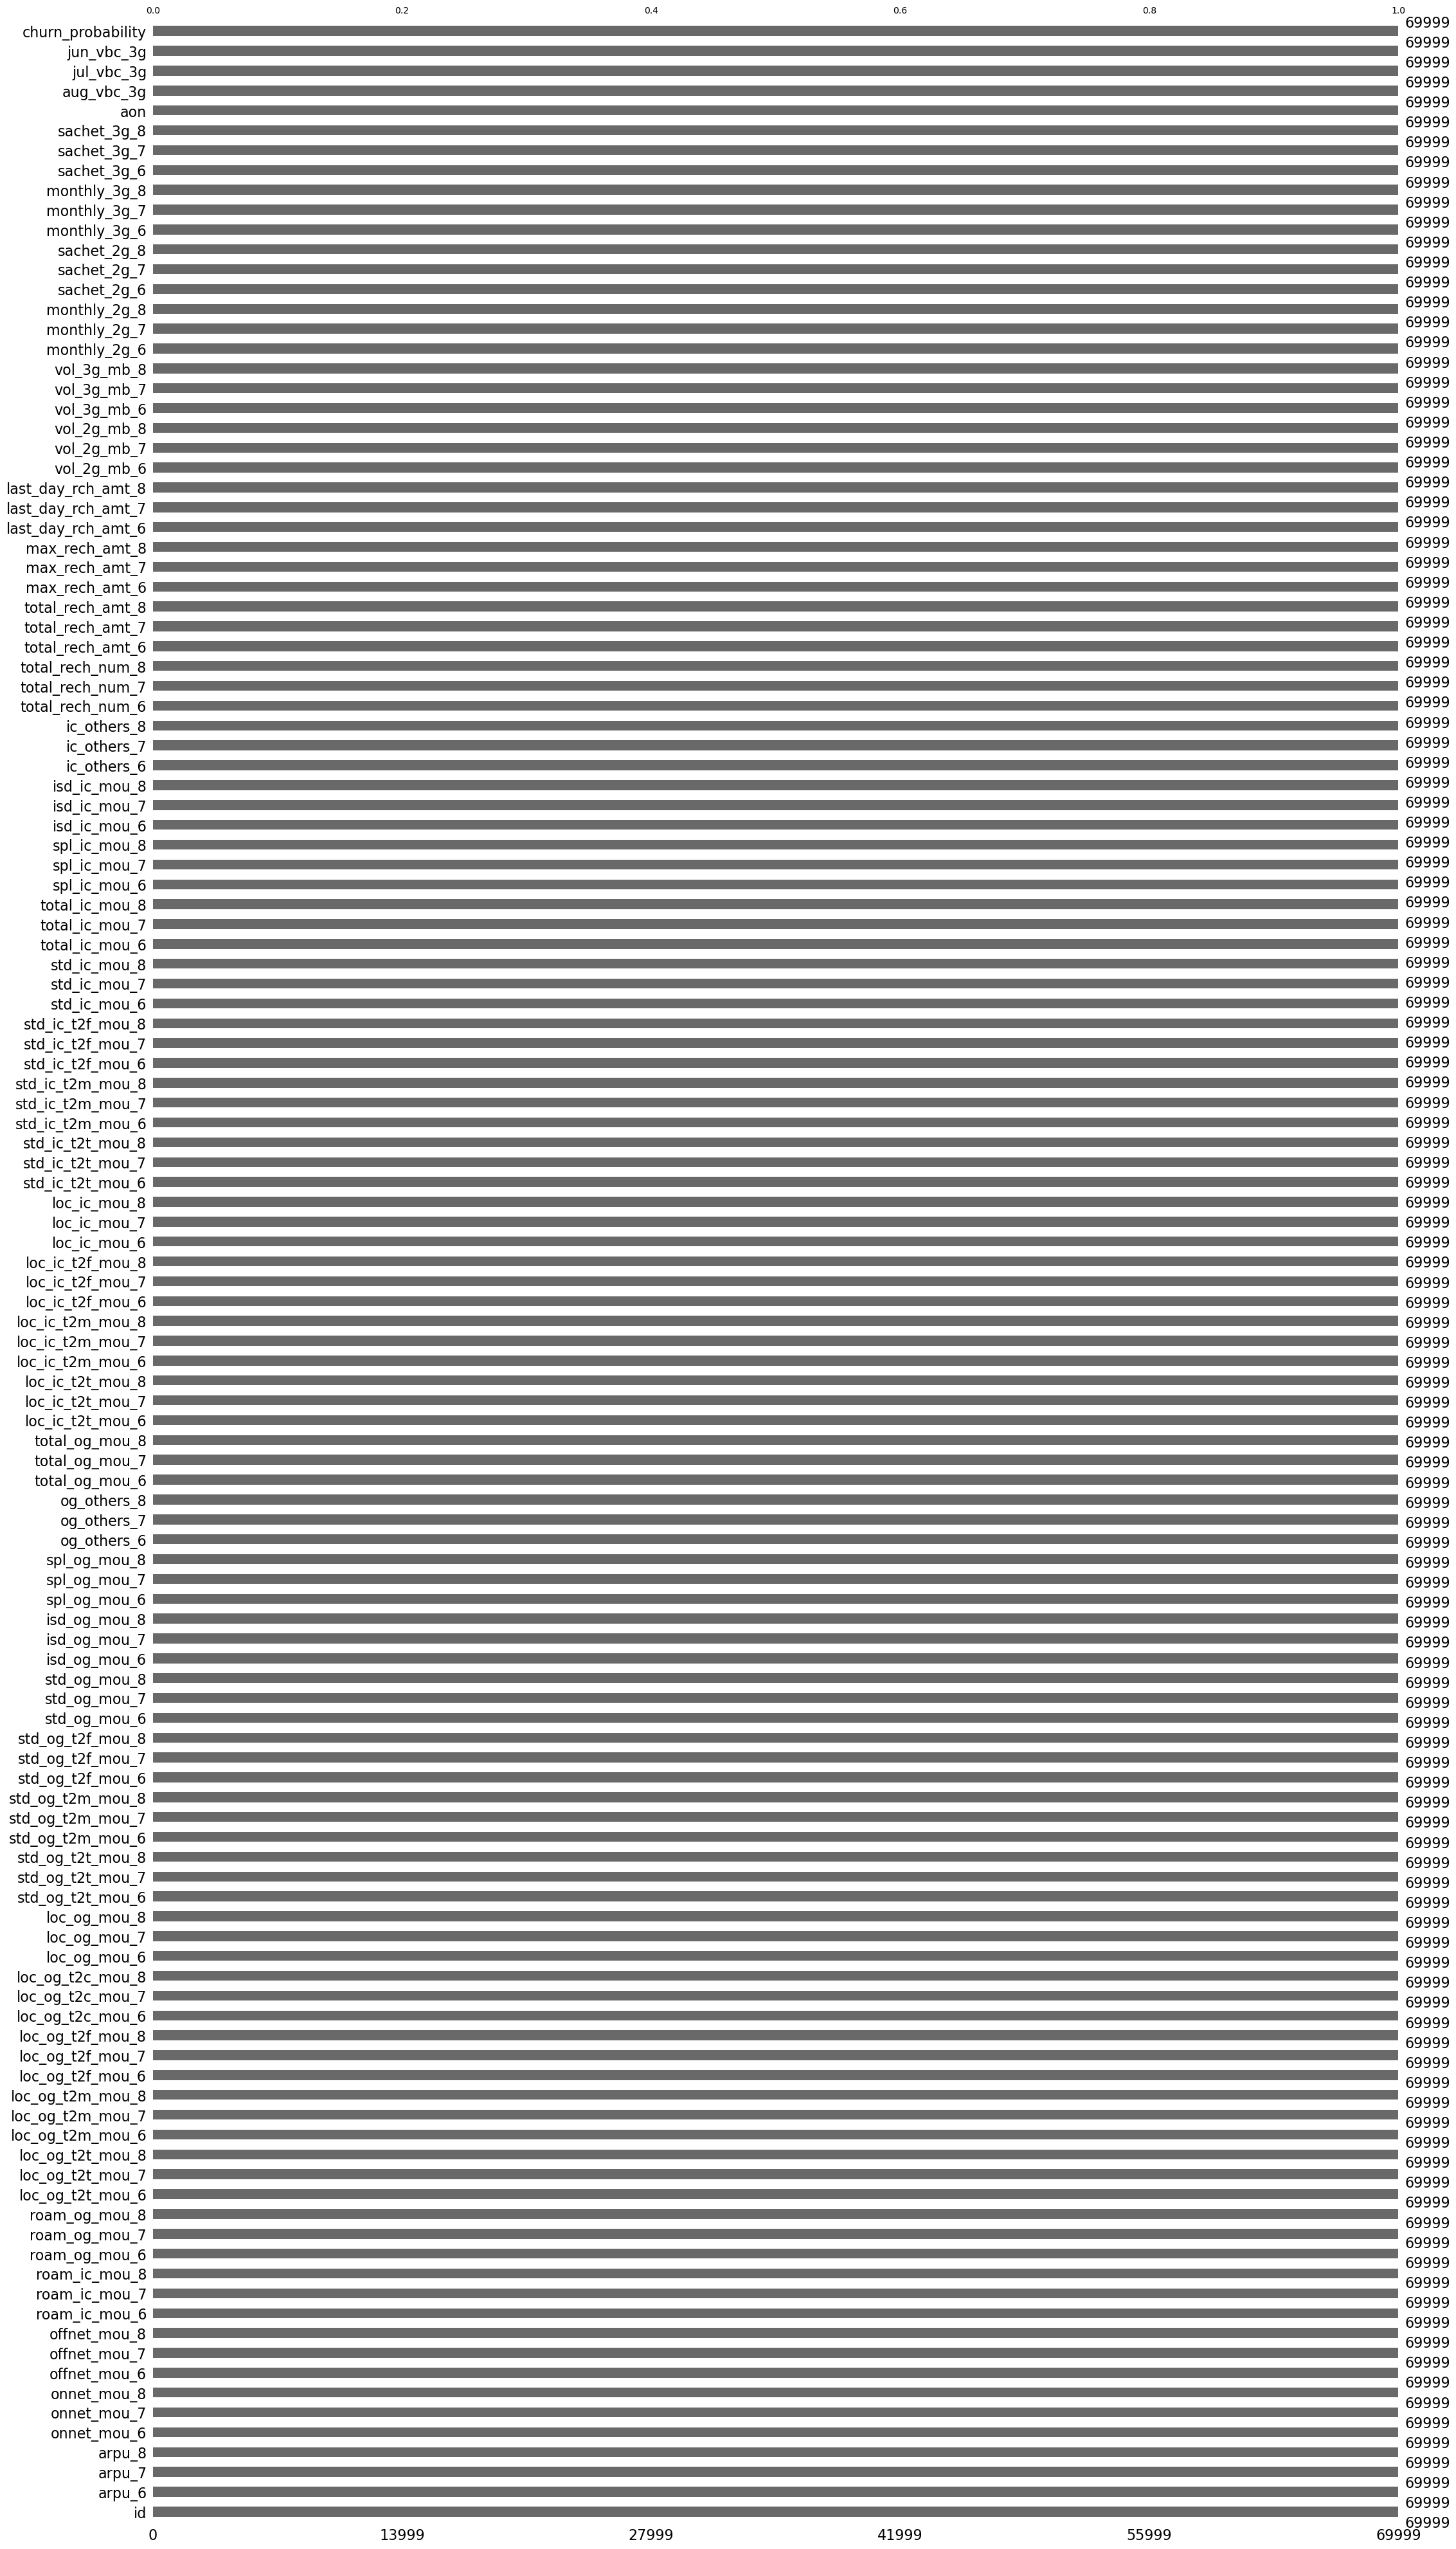

In [24]:
msno.bar(X_train_filtered)

In [25]:
X_train_filtered.describe()

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean   34999.000000    283.134365    278.185912    278.858826    127.887939   
std    20207.115084    334.213918    344.366927    351.924315    295.115497   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17499.500000     93.581000     86.714000     84.095000      5.430000   
50%    34999.000000    197.484000    191.588000    192.234000     30.830000   
75%    52498.500000    370.791000    365.369500    369.909000    113.100000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     128.754731    125.943607    191.010582    189.585401    186.146273   
std      306.326345    304.990552    312.900706    318.492632    318.453812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.910000      4.110000     28.790000     26.690000     23.780000   
50%       29.160000     27.840000     89.810000     85.590000     83.010000   
75%      108.940000    106.280000    223.540000    218.350000    216.410000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       ...  monthly_3g_7  monthly_3g_8   sachet_3g_6   sachet_3g_7  \
count  ...  69999.000000  69999.000000  69999.000000  69999.000000   
mean   ...      0.077730      0.081958      0.075344      0.081444   
std    ...      0.383189      0.381821      0.573003      0.634547   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...     16.000000     16.000000     29.000000     33.000000   

        sachet_3g_8           aon    aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.00000   
mean       0.085487   1220.639709     68.108597     65.935830     60.07674   
std        0.680035    952.426321    269.328659    267.899034    257.22681   
min        0.000000    180.000000      0.000000      0.000000      0.00000   
25%        0.000000    468.000000      0.000000      0.000000      0.00000   
50%        0.000000    868.000000      0.000000      0.000000      0.00000   
75%        0.000000   1813.000000      0.000000      0.000000      0.00000   
max       41.000000   4337.000000  12916.220000   9165.600000  11166.21000   

       churn_probability  
count       69999.000000  
mean            0.101887  
std             0.302502  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 126 columns]

# 4. Exploratory Data Analysis 

Lets start by analysing the univariate distributions of each feature.

<Axes: xlabel='churn_probability', ylabel='Count'>

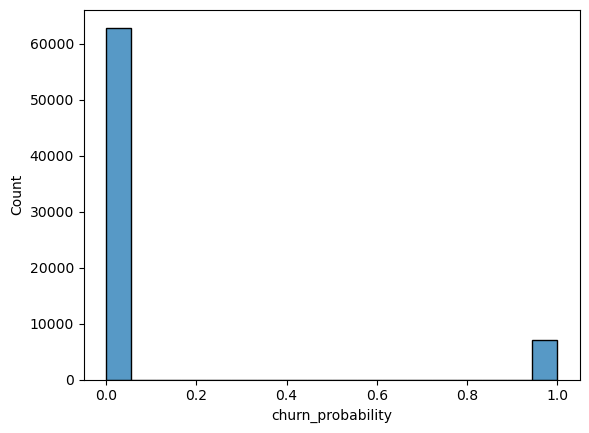

In [26]:
#Distribution for the churn probability
sns.histplot(X_train_filtered['churn_probability'])

In [27]:
plt.figure(figsize=(50,200))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

<Axes: >

# Derived features

In [28]:
# Average recharge amount for June and July
X_train_filtered['avg_rech_amt_6_7']=((X_train_filtered['total_rech_amt_6']+X_train_filtered['total_rech_amt_7'])/2)
# for test data set
unseen['avg_rech_amt_6_7']=((unseen['total_rech_amt_6']+unseen['total_rech_amt_7'])/2)

In [29]:
# Avergae of 6th and 7th month total usage
X_train_filtered['avg_total_6_7']=((X_train_filtered['total_og_mou_6']+X_train_filtered['total_og_mou_7'])/2)
# for test data set
unseen['avg_total_6_7']=((unseen['total_og_mou_6']+X_train_filtered['total_og_mou_7'])/2)

# Filtering High-Value Customers

In [30]:
# Filtering the customers based on average recharge amount
perc_6_7=X_train_filtered['avg_rech_amt_6_7'].quantile(0.70)
X_train_filtered=X_train_filtered[X_train_filtered['avg_rech_amt_6_7']>=perc_6_7]
X_train_filtered.shape

(21018, 128)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [31]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [32]:
#Remove outliers in X_train
X_train_filtered.loc[:, X_train_filtered.columns!="churn_probability"]=X_train_filtered.loc[:, X_train_filtered.columns!="churn_probability"].apply(cap_outliers, axis=0)

In [33]:
col_list = X_train_filtered.columns.to_list()
col_list.remove('churn_probability')
col_list.remove('id')

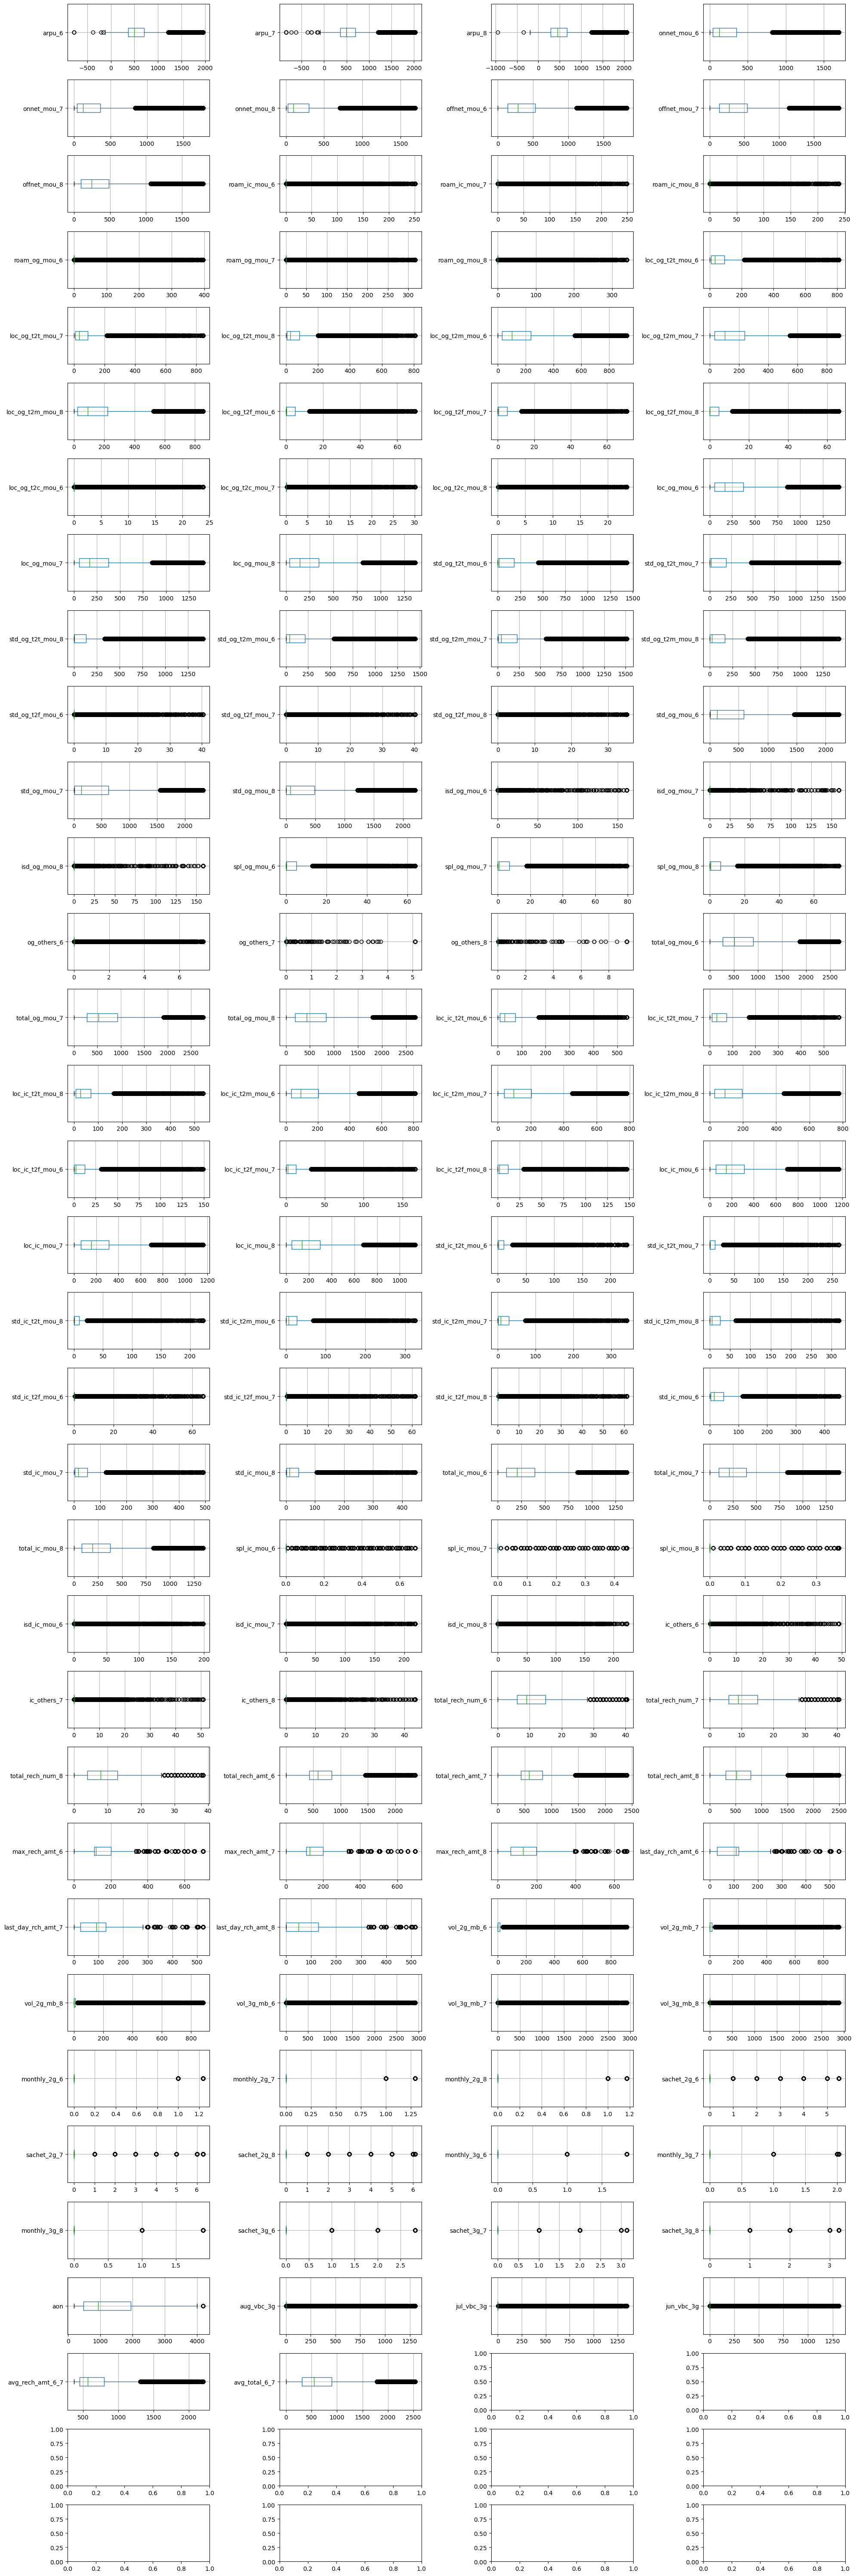

In [34]:
#Univariate analaysis
fig, ax = plt.subplots(34, 4, figsize=(20, 60))
for variable, subplot in zip(col_list, ax.flatten()):
    X_train_filtered.boxplot(column=variable, ax=subplot, vert=False)
plt.tight_layout()
plt.show()

# Check Correlation 

<Axes: >

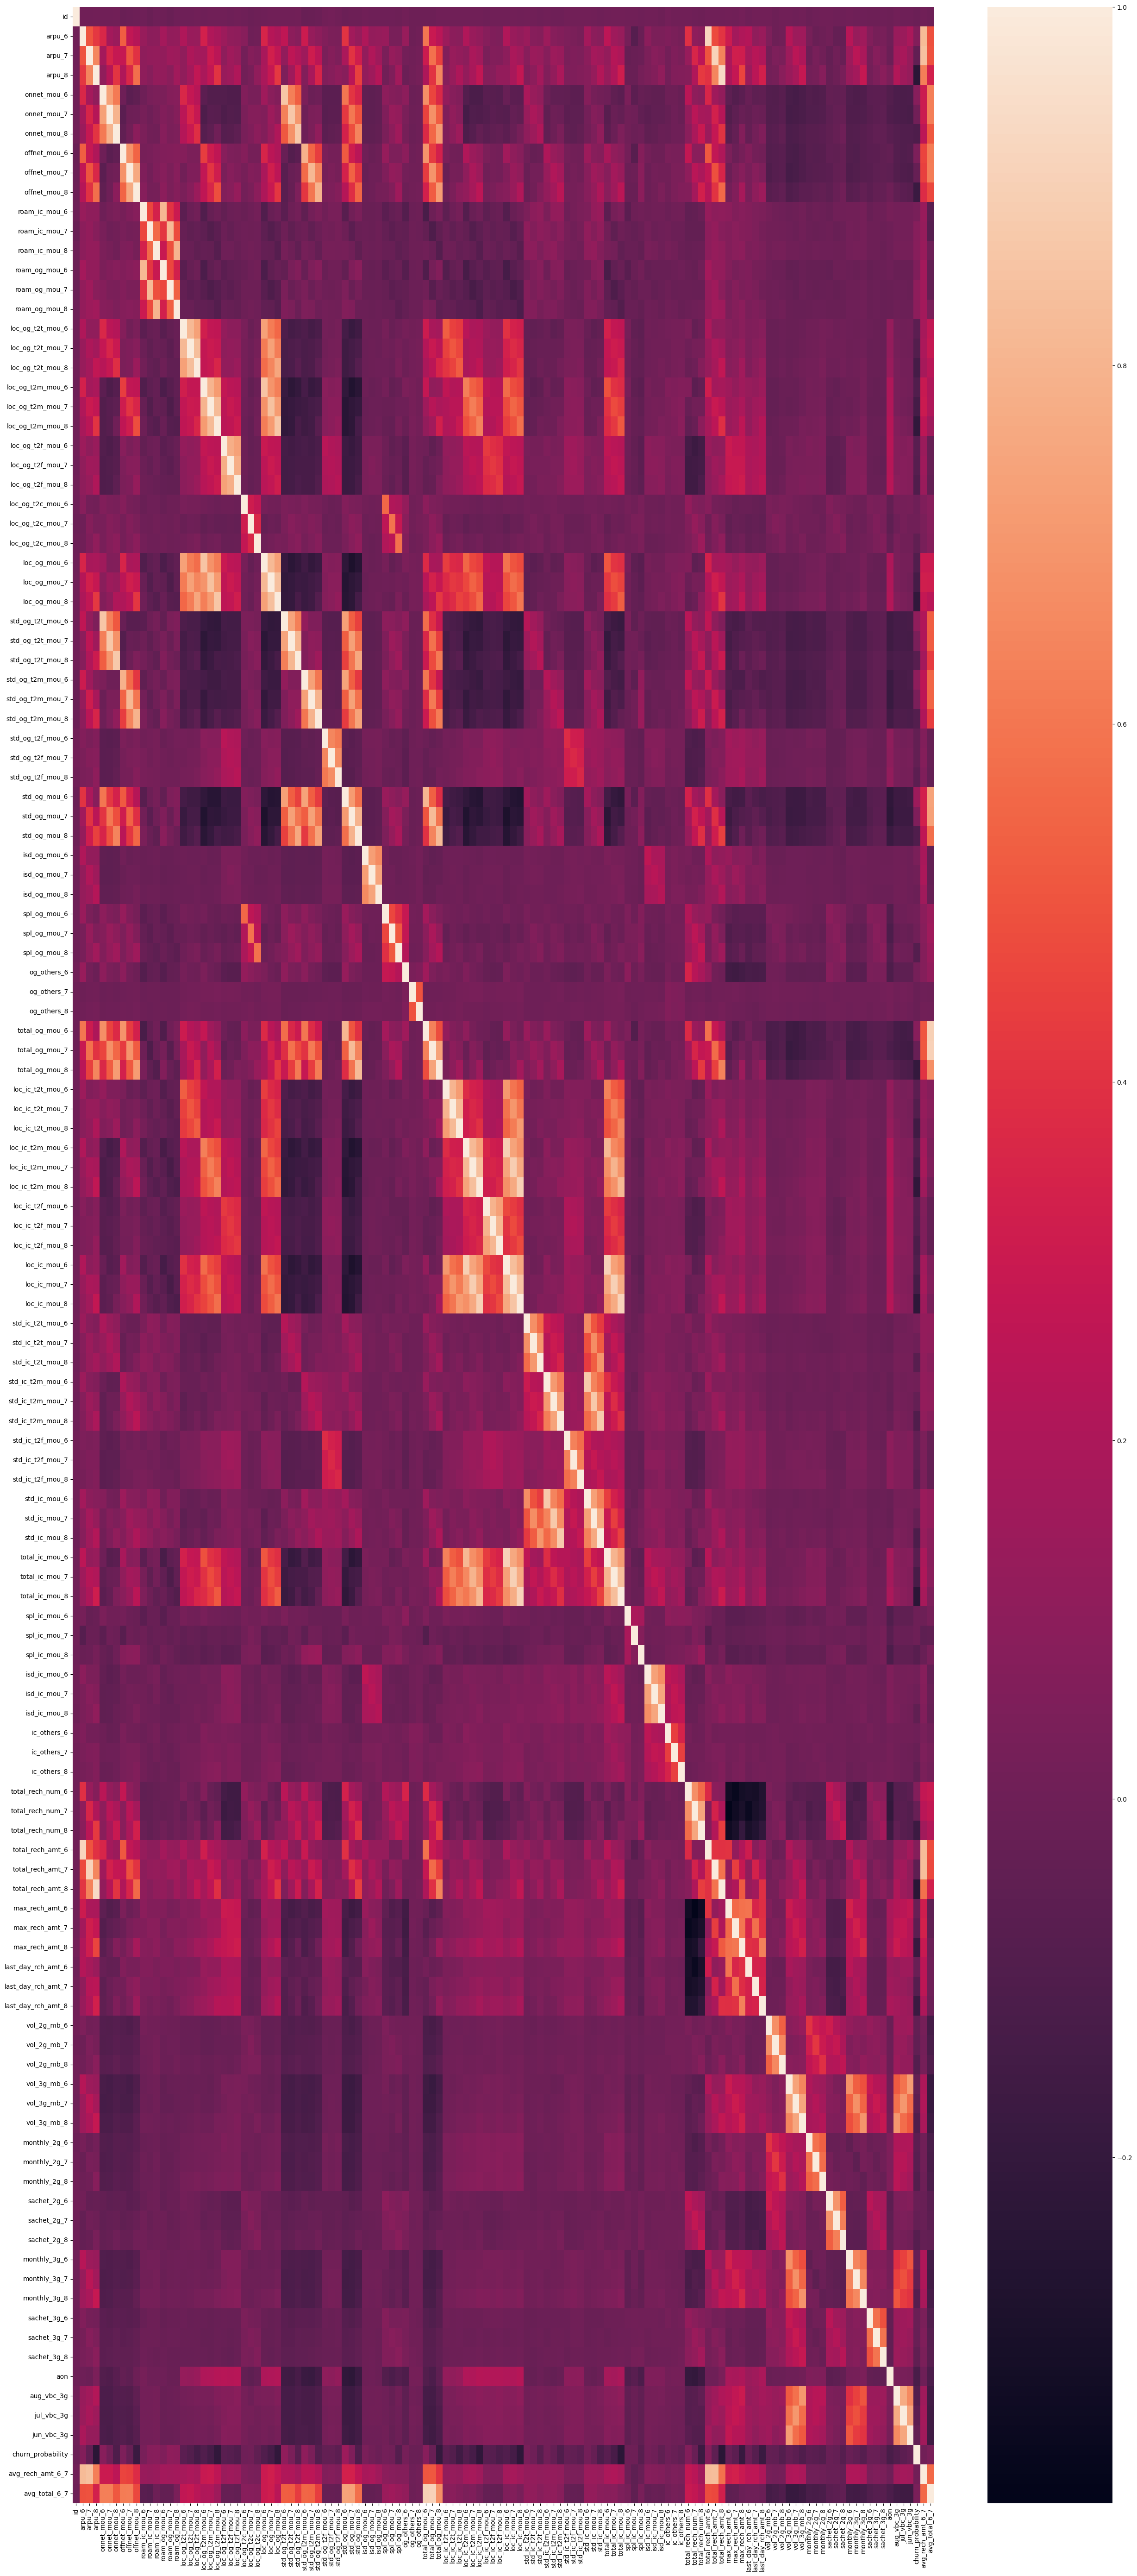

In [35]:
plt.figure(figsize=(30,70))
sns.heatmap(pd.DataFrame(X_train_filtered, columns=X_train_filtered.columns).corr())

# Create Train & Test Split

In [36]:
X = X_train_filtered.drop(['churn_probability'],axis=1)
y = X_train_filtered['churn_probability']

X.shape, y.shape

((21018, 127), (21018,))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16814, 127), (4204, 127), (16814,), (4204,))

# Scale Features

In [39]:
scale = StandardScaler()
X_train_TF = scale.fit_transform(X_train)
unseen_Scaled=scale.transform(unseen[X_train.columns])


# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [40]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_TF, y_train)

RandomForestClassifier(n_jobs=-1)

In [41]:
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})

In [42]:
#feature_importances
feature_importances.sort_values(by=['importance'], ascending=False)

col  importance
66         loc_ic_mou_8    0.051518
60     loc_ic_t2m_mou_8    0.041547
30         loc_og_mou_8    0.040870
81       total_ic_mou_8    0.040413
3                arpu_8    0.030817
54       total_og_mou_8    0.029033
96     total_rech_amt_8    0.028730
99       max_rech_amt_8    0.024356
18     loc_og_t2t_mou_8    0.023777
57     loc_ic_t2t_mou_8    0.022463
21     loc_og_t2m_mou_8    0.019286
6           onnet_mou_8    0.018132
15        roam_og_mou_8    0.018096
9          offnet_mou_8    0.016715
12        roam_ic_mou_8    0.016177
78         std_ic_mou_8    0.014995
102  last_day_rch_amt_8    0.014955
121                 aon    0.010643
42         std_og_mou_8    0.010469
72     std_ic_t2m_mou_8    0.010402
2                arpu_7    0.009970
0                    id    0.009544
1                arpu_6    0.009053
95     total_rech_amt_7    0.008726
125    avg_rech_amt_6_7    0.008620
20     loc_og_t2m_mou_7    0.008451
94     total_rech_amt_6    0.008451
65         loc_ic_mou_7    0.008429
5           onnet_mou_7    0.008403
8          offnet_mou_7    0.008360
59     loc_ic_t2m_mou_7    0.008271
56     loc_ic_t2t_mou_7    0.008261
41         std_og_mou_7    0.008243
80       total_ic_mou_7    0.008205
93     total_rech_num_8    0.008042
19     loc_og_t2m_mou_6    0.008034
92     total_rech_num_7    0.007996
4           onnet_mou_6    0.007947
7          offnet_mou_6    0.007709
53       total_og_mou_7    0.007662
58     loc_ic_t2m_mou_6    0.007628
35     std_og_t2m_mou_7    0.007623
91     total_rech_num_6    0.007555
52       total_og_mou_6    0.007515
34     std_og_t2m_mou_6    0.007477
40         std_og_mou_6    0.007364
126       avg_total_6_7    0.007360
79       total_ic_mou_6    0.007296
55     loc_ic_t2t_mou_6    0.007274
64         loc_ic_mou_6    0.007159
32     std_og_t2t_mou_7    0.007109
76         std_ic_mou_6    0.007076
11        roam_ic_mou_7    0.007072
28         loc_og_mou_6    0.007052
29         loc_og_mou_7    0.006992
97       max_rech_amt_6    0.006947
63     loc_ic_t2f_mou_8    0.006937
16     loc_og_t2t_mou_6    0.006937
17     loc_og_t2t_mou_7    0.006857
70     std_ic_t2m_mou_6    0.006726
77         std_ic_mou_7    0.006552
31     std_og_t2t_mou_6    0.006499
98       max_rech_amt_7    0.006344
14        roam_og_mou_7    0.006147
68     std_ic_t2t_mou_7    0.006099
36     std_og_t2m_mou_8    0.006036
71     std_ic_t2m_mou_7    0.005812
67     std_ic_t2t_mou_6    0.005457
107         vol_3g_mb_7    0.005456
47         spl_og_mou_7    0.005346
101  last_day_rch_amt_7    0.005258
48         spl_og_mou_8    0.005113
69     std_ic_t2t_mou_8    0.004909
33     std_og_t2t_mou_8    0.004838
46         spl_og_mou_6    0.004812
100  last_day_rch_amt_6    0.004769
108         vol_3g_mb_8    0.004697
62     loc_ic_t2f_mou_7    0.004682
61     loc_ic_t2f_mou_6    0.004675
105         vol_2g_mb_8    0.004389
122          aug_vbc_3g    0.004027
24     loc_og_t2f_mou_8    0.003773
23     loc_og_t2f_mou_7    0.003702
22     loc_og_t2f_mou_6    0.003627
26     loc_og_t2c_mou_7    0.003464
85         isd_ic_mou_6    0.003447
86         isd_ic_mou_7    0.003345
82         spl_ic_mou_6    0.003257
88          ic_others_6    0.003250
13        roam_og_mou_6    0.003250
89          ic_others_7    0.003216
10        roam_ic_mou_6    0.003112
104         vol_2g_mb_7    0.003031
49          og_others_6    0.002949
25     loc_og_t2c_mou_6    0.002940
103         vol_2g_mb_6    0.002785
73     std_ic_t2f_mou_6    0.002504
44         isd_og_mou_7    0.002404
90          ic_others_8    0.002397
106         vol_3g_mb_6    0.002344
117        monthly_3g_8    0.002267
74     std_ic_t2f_mou_7    0.002220
123          jul_vbc_3g    0.002214
27     loc_og_t2c_mou_8    0.002196
43         isd_og_mou_6    0.002050
87         isd_ic_mou_8    0.002032
113         sachet_2g_7    0.001936
124          jun_vbc_3g    0.001923
45         isd_og_mou_8    0.001716
116        monthly_3g_7    0.001643
38     std_og_t2f_mou_7 

In [43]:
plt.figure(figsize=(50,250))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<BarContainer object of 127 artists>

## Top Important Featutres are as below:
#### 1.loc_ic_mou_8	
#### 2.total_ic_mou_8	
#### 3.loc_ic_t2m_mou_8	
#### 4.loc_og_mou_8	
#### 5.arpu_8
#### 6.loc_og_t2m_mou_8	
#### 7.offnet_mou_8

# PCA

In [44]:
pca = PCA()
pca_components = pca.fit_transform(X_train_TF)


In [45]:
pca.components_

array([[ 5.34072052e-03,  1.00896881e-01,  1.10909811e-01, ...,
         4.72812951e-02,  1.21288238e-01,  5.67540328e-02],
       [-5.70144893e-04,  1.18698284e-01,  1.46578245e-01, ...,
        -6.73511959e-02,  1.52779998e-01,  2.47088976e-01],
       [ 1.75868656e-03,  1.06876317e-01,  1.40455492e-01, ...,
         2.01448565e-01,  1.43312579e-01, -4.41811789e-02],
       ...,
       [ 4.27132435e-04, -2.01359802e-03,  4.17323008e-03, ...,
        -5.95899954e-04, -7.10056443e-02,  6.58392281e-01],
       [-4.54193660e-04, -4.60067453e-03, -9.83593316e-04, ...,
         9.39709292e-04, -4.79142570e-03,  2.31215478e-01],
       [ 3.63729823e-04,  1.15993962e-03, -1.47666399e-03, ...,
        -1.15758697e-03,  1.06515171e-02,  1.24108337e-01]])

In [46]:
pca.explained_variance_ratio_

array([1.21624194e-01, 9.90464355e-02, 6.02648751e-02, 4.90311557e-02,
       3.96128261e-02, 3.68171627e-02, 2.92029206e-02, 2.88151946e-02,
       2.68764161e-02, 2.49209719e-02, 2.23672484e-02, 2.20305132e-02,
       1.96630713e-02, 1.86243190e-02, 1.73606238e-02, 1.68114936e-02,
       1.46374854e-02, 1.32628614e-02, 1.26047863e-02, 1.24022853e-02,
       1.15378102e-02, 1.08666010e-02, 1.06553909e-02, 1.05106600e-02,
       9.73825144e-03, 8.95238257e-03, 8.37071626e-03, 8.09219844e-03,
       7.88966905e-03, 7.87770204e-03, 7.58828153e-03, 7.03796609e-03,
       6.92407619e-03, 6.88482652e-03, 6.59321735e-03, 6.30779471e-03,
       6.16056931e-03, 6.05420990e-03, 5.84112424e-03, 5.79531836e-03,
       5.68229284e-03, 5.43583685e-03, 5.18259495e-03, 5.11829560e-03,
       4.93823213e-03, 4.77053224e-03, 4.52959896e-03, 4.27146744e-03,
       4.18658881e-03, 4.11448108e-03, 3.89800018e-03, 3.88641009e-03,
       3.70513007e-03, 3.62259586e-03, 3.54515289e-03, 3.51906901e-03,
      

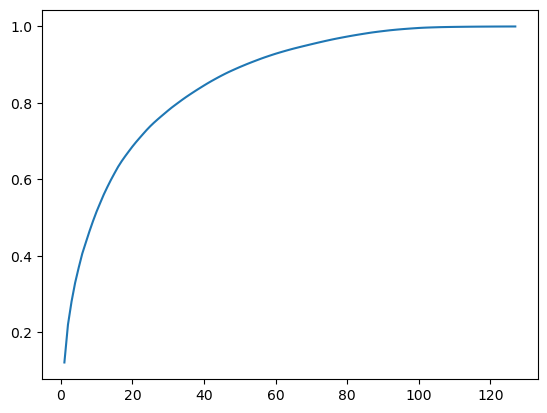

In [47]:
#Scar plot to understand the components covering maximum variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [48]:
#50 Components covers almost 85% variance 
pc2 = PCA(n_components=50, random_state=42)

In [49]:
pca_components_2 = pc2.fit_transform(X_train_TF)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [50]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf.fit(pca_components_2, y_train)

feature_importances_pca = pd.DataFrame({'col':['component_'+str(i) for i in range(50)], 
                                    'importance':rf.feature_importances_})
feature_importances_pca.sort_values(by=['importance'], ascending=False)


col  importance
0    component_0    0.083158
6    component_6    0.076270
17  component_17    0.057591
7    component_7    0.051048
8    component_8    0.024211
1    component_1    0.021960
22  component_22    0.021536
2    component_2    0.020323
4    component_4    0.019657
3    component_3    0.019115
37  component_37    0.018438
44  component_44    0.017980
31  component_31    0.017963
30  component_30    0.017679
11  component_11    0.017201
49  component_49    0.016966
36  component_36    0.016942
35  component_35    0.016830
41  component_41    0.016582
38  component_38    0.016558
43  component_43    0.015950
32  component_32    0.015885
15  component_15    0.015747
29  component_29    0.015633
9    component_9    0.015556
47  component_47    0.015447
5    component_5    0.015396
34  component_34    0.015294
40  component_40    0.015190
23  component_23    0.015031
42  component_42    0.014919
28  component_28    0.014550
33  component_33    0.014340
19  component_19    0.014277
12  component_12    0.014271
18  component_18    0.014265
14  component_14    0.014238
27  component_27    0.014192
39  component_39    0.014088
16  component_16    0.013971
46  component_46    0.013848
45  component_45    0.013829
10  component_10    0.013758
13  component_13    0.013582
26  component_26    0.013506
48  component_48    0.013370
25  component_25    0.013258
21  component_21    0.013132
20  component_20    0.012771
24  component_24    0.012697

<BarContainer object of 127 artists>

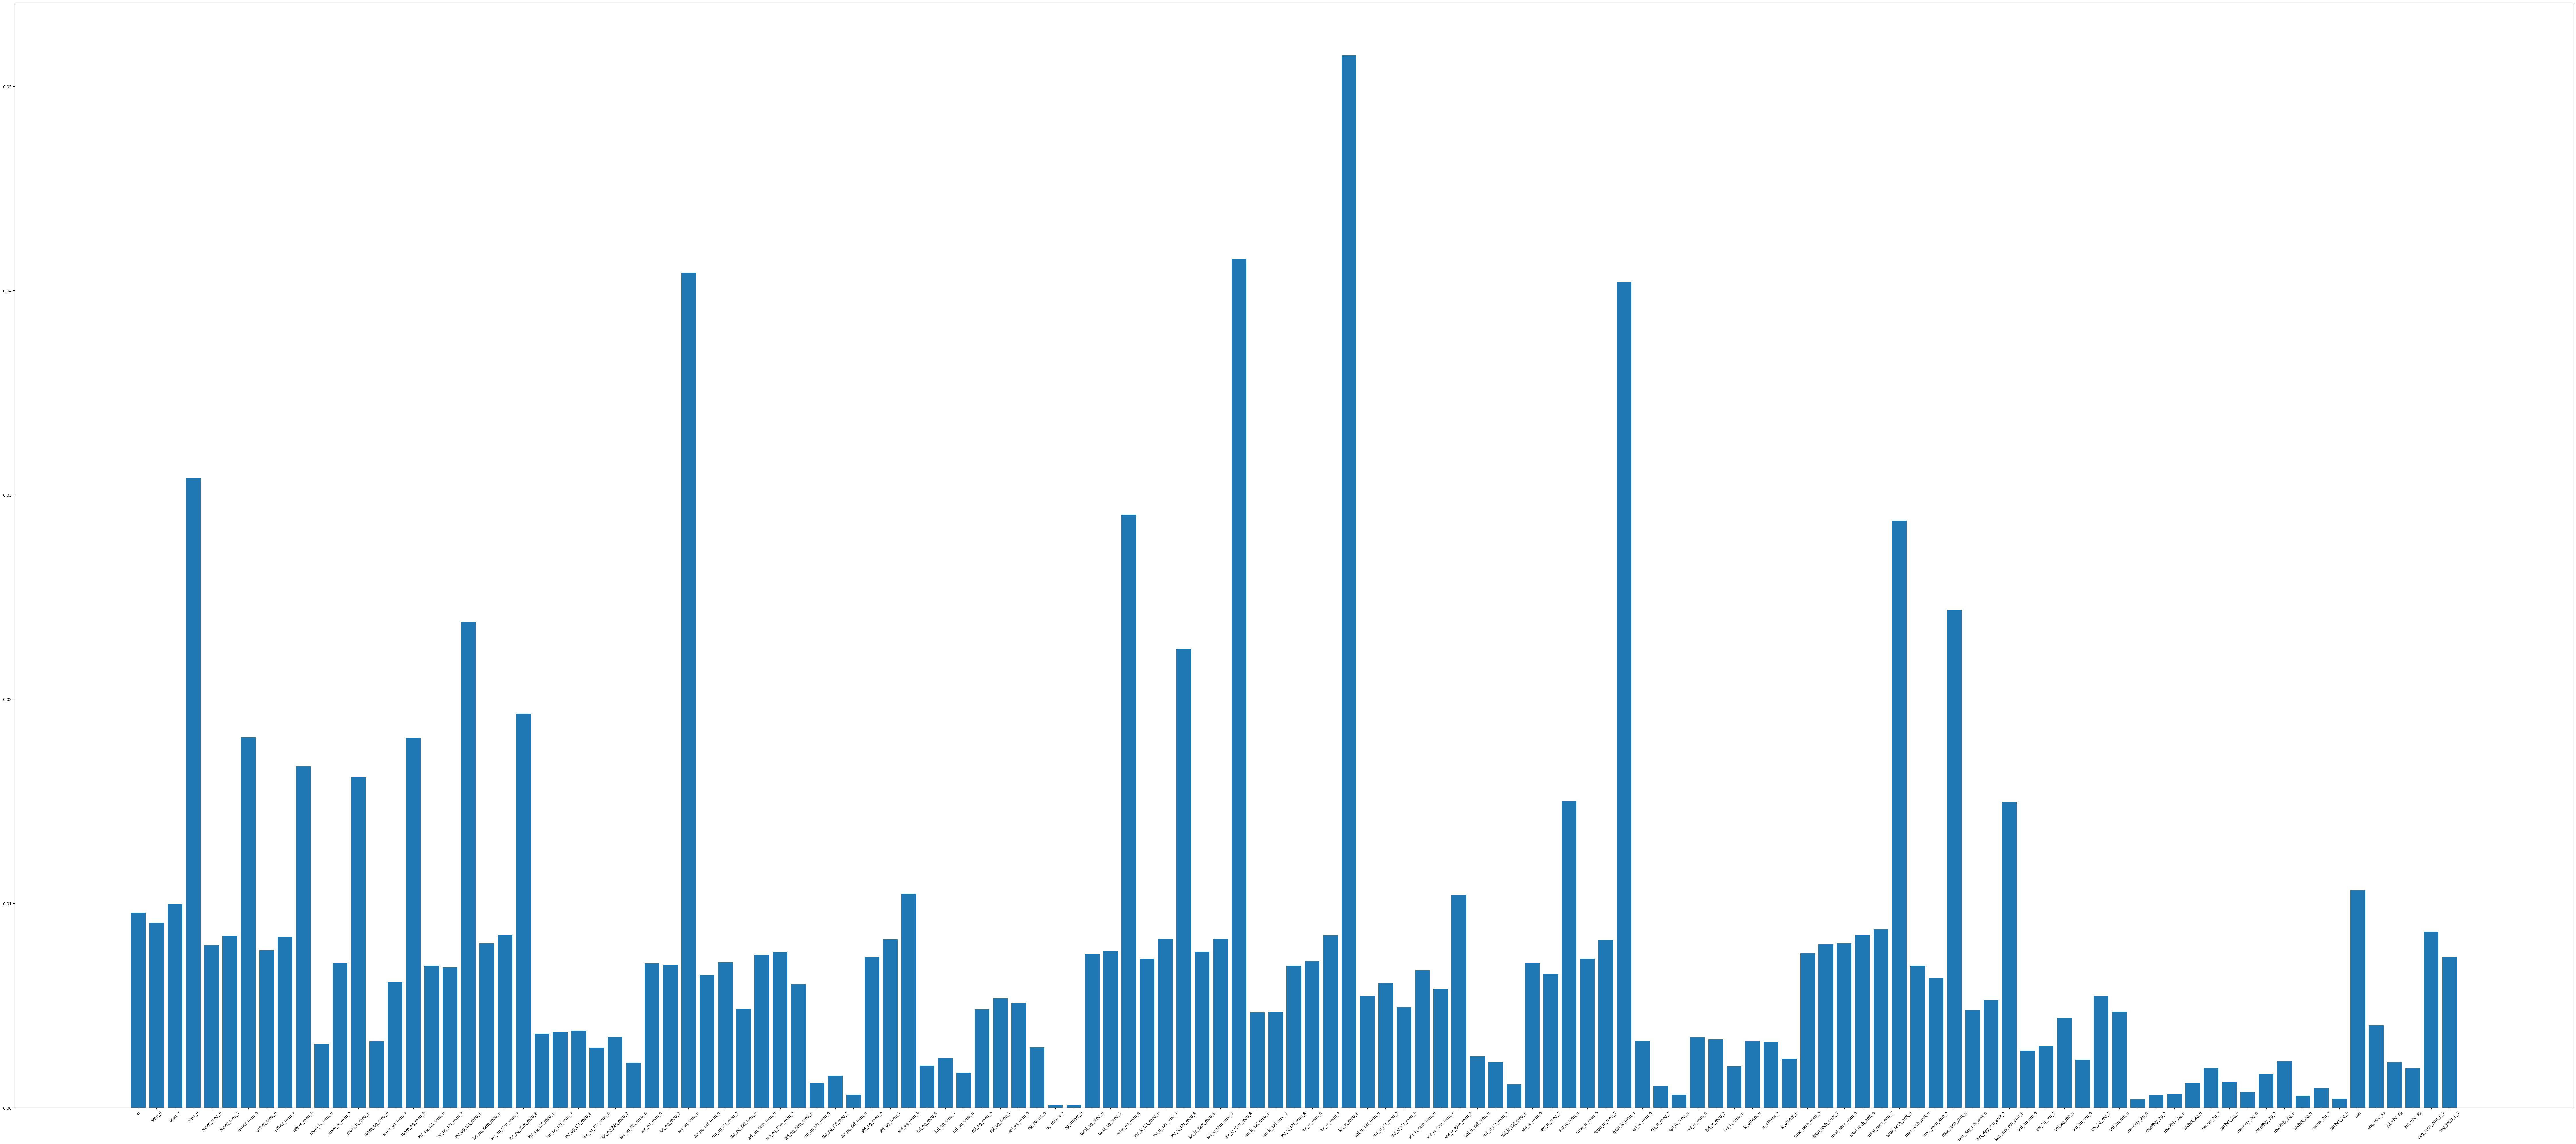

In [51]:
plt.figure(figsize=(115,50))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# Model Building using LR

In [52]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components_2, y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [53]:
lr.score(pca_components_2, y_train)

0.9244082312358749

# ##
The model has 92.4% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -

Imputation
Scaling
PCA
Classification model
You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [54]:
imp1 = SimpleImputer(strategy='constant', fill_value=0)
scale1 = StandardScaler()
pca3 = PCA(n_components=50)
lr1 = LogisticRegression(max_iter=1000, tol=0.001)

In [55]:
pipe = Pipeline(steps = [('imputation',imp1),
                         ('scaling',scale1),
                         ('pca',pca3),
                         ('model',lr1)])

In [56]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=50)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [57]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9235755917687641


In [58]:
test_score = pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9238820171265462


In [59]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[15071,   259],
       [ 1026,   458]], dtype=int64)

In [60]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[3771,   58],
       [ 262,  113]], dtype=int64)

In [61]:
precision_score(y_test, pipe.predict(X_test))

0.6608187134502924

In [62]:
recall_score(y_test, pipe.predict(X_test))

0.30133333333333334

# Model Building Using Random Classifier

In [63]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [64]:
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [10,20,30,40],
    'n_estimators': [10, 30, 50, 100, 200]
}

# Randomised Search for Hyper Parameter Tuning

In [65]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = classifier_rf, param_distributions = params, cv = 10, verbose=2, n_jobs = 4)


In [66]:
rf_RandomGrid.fit(X_train_TF, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=4,
                   param_distributions={'max_depth': [1, 2, 5, 10, 20],
                                        'max_features': [10, 20, 30, 40],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100],
                                        'n_estimators': [10, 30, 50, 100, 200]},
                   verbose=2)

In [67]:
rf_RandomGrid.best_params_

{'n_estimators': 30,
 'min_samples_leaf': 10,
 'max_features': 20,
 'max_depth': 5}

In [68]:
rf_best=rf_RandomGrid.best_estimator_

In [69]:
rf_best

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=10,
                       n_estimators=30, n_jobs=-1, random_state=42)

In [70]:
rf_RandomGrid.best_score_

0.9392771982590625

In [71]:
rf_best.fit(X_train_TF, y_train)

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=10,
                       n_estimators=30, n_jobs=-1, random_state=42)

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [73]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train_TF)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train_TF)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [74]:
evaluate_model(rf_best)

Train Accuracy : 0.9409420720827881
Train Confusion Matrix:
[[15091   239]
 [  754   730]]
--------------------------------------------------
Test Accuracy : 0.9107992388201712
Test Confusion Matrix:
[[3829    0]
 [ 375    0]]


# Creating submission file for RF Model

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [75]:
unseen_Scaled.shape

(30000, 127)

In [76]:
submission_data=unseen_Scaled
submission_data.shape

(30000, 127)

In [77]:
unseen['churn_probability'] = rf_best.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  1
3  70002                  0
4  70003                  0

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [78]:
output.to_csv('Tejas_KDA_Deenaz_Khanum_RF.csv',index=False)

In [381]:
#pip install xgboost

# Handling Imbalanace data using Smote Technique

In [84]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

# XGBOOST

In [85]:
import xgboost as xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [86]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_smote, y_train_smote)  # default 
# Get our predictions
xgb_predictions = xgb_cfl.predict(X_test)

In [87]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test)
xgb_predictions_prob

array([[0.9954612 , 0.00453879],
       [0.99309695, 0.00690303],
       [0.96426266, 0.03573735],
       ...,
       [0.7439225 , 0.2560775 ],
       [0.99804723, 0.00195274],
       [0.9826766 , 0.0173234 ]], dtype=float32)

In [88]:
accuracy_score(y_test, xgb_predictions)

0.9269743101807802